## Traction Analytics Prediction

### Methodology

1. Data Preparation
- Concat daily downloads of weekly article activities from NewsWhip
- Calculate percentage and absolute change of each article across days

2. Define labels
- Set gradient threshold and abs interaction value threshold
- For each article, build a linear regression model for the facebook interactions over time and obtain the gradient
- If the gradient > threshold | abs interaction count > threshold -> trending
- Else if the gradient < -threshold -> untrending
- Else -> neutral

3. EDA of labels
- Readjust threholds if necessary
- Under or oversampling if necessary

4. Deep learning pipeline (SetFit for Few Shot)
- Tokenise
- Train-test split : 80/20
- Model evaluation using precision, recall and F1
- Model comparison

### Data Preperation

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [74]:
# Read and perform basic data processing

df = pd.read_csv('data/combined_data_merged.csv')
df = df[['published', 'headline', 'summary', 'link', 'domain','facebook_interactions', 'date_extracted']]
df['published'] = pd.to_datetime(df['published'])
df['date_extracted'] = pd.to_datetime(df['date_extracted'])
df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)

df

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09
...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08


In [75]:
# Create a dataframe with unique articles only

df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)
df_unique

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09
...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16


### Domain Analysis

In [76]:
df_unique['domain'].value_counts()

straitstimes.com                    285
mothership.sg                       276
asiaone.com                         169
channelnewsasia.com                 158
mustsharenews.com                    86
sg.news.yahoo.com                    80
sg.style.yahoo.com                   63
todayonline.com                      48
stomp.straitstimes.com               42
cnalifestyle.channelnewsasia.com     39
tnp.straitstimes.com                 32
sg.finance.yahoo.com                 12
babelfish.mothership.sg              11
coconuts.co                           6
goodyfeed.com                         6
businesstimes.com.sg                  4
au.news.yahoo.com                     4
uk.news.yahoo.com                     3
theonlinecitizen.com                  2
au.lifestyle.yahoo.com                2
ricemedia.co                          2
cnaluxury.channelnewsasia.com         2
malaysia.news.yahoo.com               1
public.flourish.studio                1
Name: domain, dtype: int64

In [77]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key
        
reverse_domain_map

{'asiaone.com': 'asiaone',
 'businesstimes.com.sg': 'businesstimes',
 'channelnewsasia.com': 'channelnewsasia',
 'cnalifestyle.channelnewsasia.com': 'channelnewsasia',
 'cnaluxury.channelnewsasia.com': 'channelnewsasia',
 'goodyfeed.com': 'goodyfeed',
 'babelfish.mothership.sg': 'mothership',
 'mothership.sg': 'mothership',
 'mustsharenews.com': 'mustsharenews',
 'ricemedia.co': 'ricemedia',
 'straitstimes.com': 'straitstimes',
 'stomp.straitstimes.com': 'stomp',
 'tnp.straitstimes.com': 'thenewpaper',
 'theonlinecitizen.com': 'theonlinecitizen',
 'todayonline.com': 'today',
 'sg.finance.yahoo.com': 'yahoosingapore',
 'sg.news.yahoo.com': 'yahoosingapore',
 'sg.style.yahoo.com': 'yahoosingapore'}

In [78]:
domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],

}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})
traffic_table

,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,asiaone,4990000,1290000
1,businesstimes,1630000,622688
2,channelnewsasia,14760000,2330000
3,goodyfeed,891376,461731
4,mothership,6770000,1660000
5,mustsharenews,2010000,823526
6,ricemedia,148791,86394
7,straitstimes,12310000,2230000
8,stomp,1270000,427113
9,theindependent,2370000,683818


Filtering data to include only articles present in mapping table

In [79]:
df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09
...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08


In [80]:
df_filtered = df_unique[df_unique["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df_filtered

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09
...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16


In [81]:
# mapping domain to domain group

df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)
df_filtered

C:\Users\edmun\AppData\Local\Temp\ipykernel_26972\2727172548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia
...,...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13,today
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12,today
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12,today
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16,today


In [82]:
# merge traffic table with df_filtered on domain and domain_group respectively

df_unique = df_filtered.merge(traffic_table, on='domain_group', how='left')
df_unique


,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000
...,...,...,...,...,...,...,...,...,...,...
1312,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13,today,3660000,1170000
1313,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12,today,3660000,1170000
1314,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12,today,3660000,1170000
1315,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16,today,3660000,1170000


In [83]:
# Calculate the absolute and percentage change in facebook interactions for each article

df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)
df

C:\Users\edmun\AppData\Local\Temp\ipykernel_26972\688441503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
C:\Users\edmun\AppData\Local\Temp\ipykernel_26972\688441503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,facebook_interactions_abs_change,facebook_interactions_pct_change
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,0.0,0.000000
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,101.0,0.074759
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,182.0,0.125344
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,49.0,0.029988
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,25.0,0.014854
...,...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04,0.0,0.000000
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05,84.0,0.107143
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07,170.0,0.195853
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08,32.0,0.030829


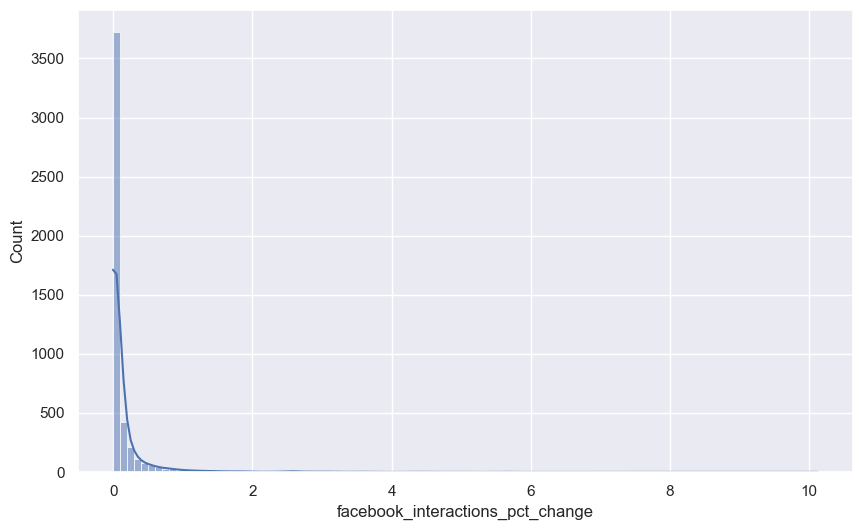

In [84]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions_pct_change', bins=100, kde=True)
plt.show()


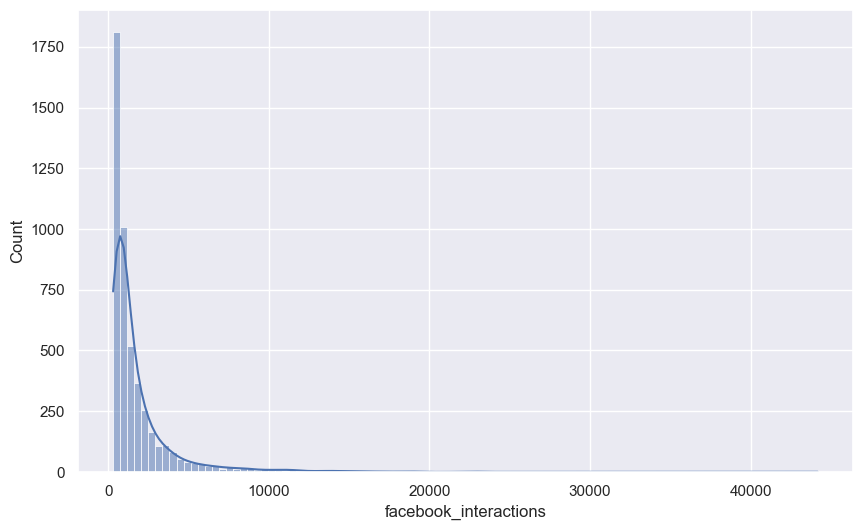

In [85]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions', bins=100, kde=True)
plt.show()


#### Method 1: Using raw PCT change

Benefits:
- Considers daily spikes without smoothening
- Simple to explain

Issues:
- facebook interaction is cumulative
- no information about sustained increase of activity

In [86]:
# PCT_THRESHOLD = 0.10

In [87]:
# # Creating a custom group by function to determine if an article is trending, not trending or neutral based on the percentage change in facebook interactions

# def label_by_pct_change(pct_changes):
#     pct_changes = np.asarray(pct_changes)
#     label = 'neutral'
#     for pct_change in pct_changes:
#         if pct_change > PCT_THRESHOLD:
#             label = 'trending'
#         elif pct_change < -PCT_THRESHOLD:
#             label = 'not trending'
#     return label

# # Create a dataframe with unique articles and their corresponding labels

# df_labels = df.groupby('link')['facebook_interactions_pct_change'].agg(label_by_pct_change).reset_index()
# df_labels

#### Method 2: Using gradient within each article

Benefits:
- Smoothens based on weekly activities

Issues:
- Reduces impact of spikes
- Gradient threshold not very explainable

In [88]:
from sklearn.linear_model import LinearRegression

In [110]:
GRD_THRESHOLD = 0
VAL_ARR_THRESHOLD_UPPER = 0
VAL_ARR_THRESHOLD_LOWER = 0

In [111]:
# Creating a custom group by function to determine if an article is trending, not trending or neutral based on the percentage change in facebook interactions

def label_by_LR(val_array):
    val_array = np.asarray(val_array)
    label = 'neutral'
    # scale val_array to be between 0 and 1
    val_array = (val_array - np.min(val_array)) / max((np.max(val_array) - np.min(val_array)), 0.000001)
    # replace nan values with 0
    val_array = np.nan_to_num(val_array)
    # build linear regression model for val_array array and obtain gradient
    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]
    
    if gradient > GRD_THRESHOLD or np.mean(val_array) > VAL_ARR_THRESHOLD_UPPER:
        label = 'trending'

    elif gradient < -GRD_THRESHOLD or np.mean(val_array) < VAL_ARR_THRESHOLD_LOWER:
        label = 'not trending'

    return (label, gradient, np.mean(val_array))


### Using Abs Values

In [91]:
# sns.histplot(data=df_labelled, x='label', bins=100, kde=True)

In [116]:
GRD_THRESHOLD = 0.5
VAL_ARR_THRESHOLD_UPPER = 0.7
VAL_ARR_THRESHOLD_LOWER = 0.25

In [117]:
# Create a dataframe with unique articles and their corresponding labels

df_labels = df.groupby('link')['facebook_interactions'].agg(label_by_LR).reset_index()

# Merge the unique articles dataframe with the labels dataframe

df_labelled = df_unique.merge(df_labels, on='link', how='left')
df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'rule_output'})
df_labelled['label'] = df_labelled['rule_output'].apply(lambda x: x[0])
df_labelled['gradient'] = df_labelled['rule_output'].apply(lambda x: x[1])
df_labelled['mean'] = df_labelled['rule_output'].apply(lambda x: x[2])
df_labelled.drop(columns=['rule_output'], inplace=True)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,label,gradient,mean
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000,neutral,0.264706,0.601120
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000,neutral,0.264922,0.662016
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000,neutral,0.233425,0.697937
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526,trending,0.319807,0.700483
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000,trending,0.304018,0.739955


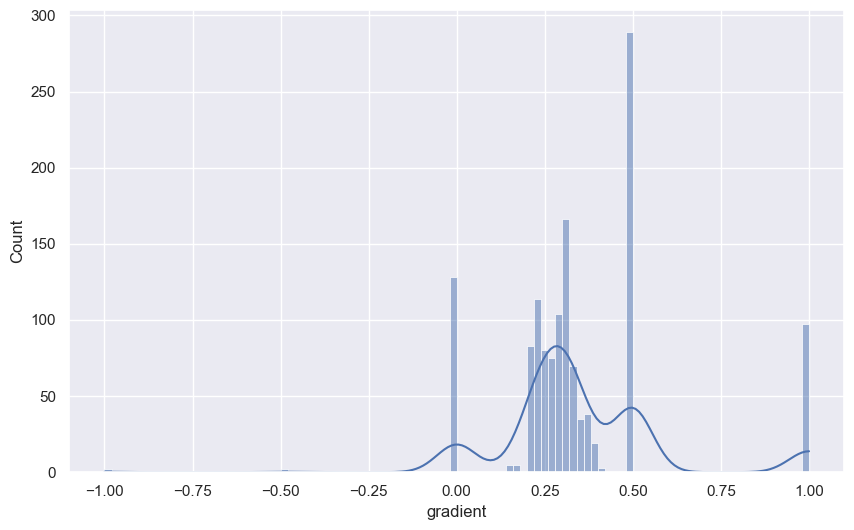

In [108]:
# plotting distribution of gradient

plt.figure(figsize=(10, 6))
sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True)
plt.show()


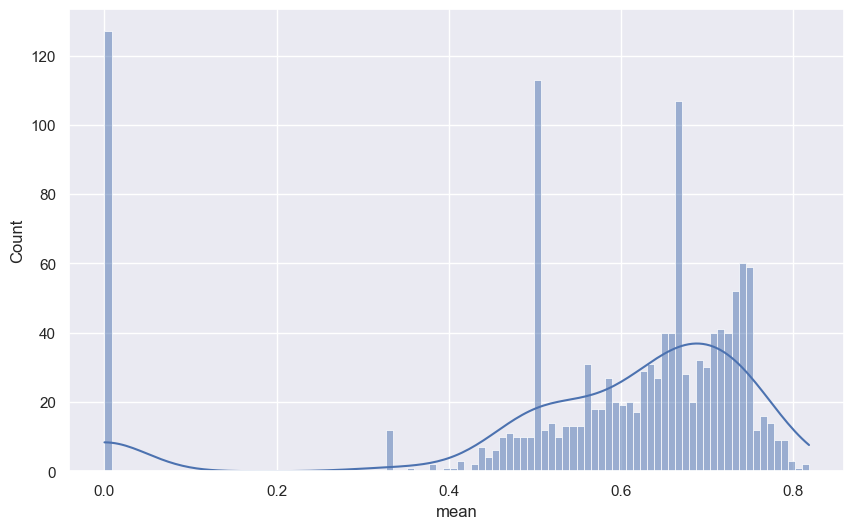

In [109]:
# plotting distribution of mean

plt.figure(figsize=(10, 6))
sns.histplot(data=df_labelled, x='mean', bins=100, kde=True)
plt.show()

### Using PCT Change

In [94]:
# GRD_THRESHOLD = 0.1
# VAL_ARR_THRESHOLD = 0.05

In [95]:
# # Create a dataframe with unique articles and their corresponding labels

# df_labels = df.groupby('link')['facebook_interactions_pct_change'].agg(label_by_LR).reset_index()
# df_labelled = df_unique.merge(df_labels, on='link', how='left')
# df_labelled = df_labelled.rename(columns={'facebook_interactions_pct_change': 'label'})
# df_labelled.head()

### EDA of target variables

In [118]:
# Perform basic data exploration of target variable

df_labelled['label'].value_counts()


neutral         721
trending        467
not trending    129
Name: label, dtype: int64

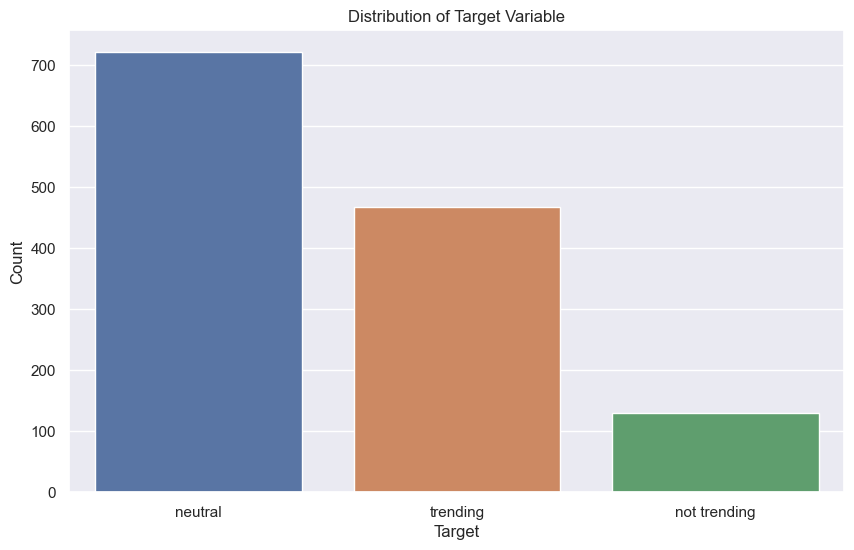

In [119]:
# Plot the distribution of target variable using Seaborn. 

plt.figure(figsize=(10, 6))
sns.countplot(data=df_labelled, x='label')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [121]:
# previewing trending articles

df_labelled[df_labelled['label'] == 'trending'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,label,gradient,mean
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526,trending,0.319807,0.700483
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000,trending,0.304018,0.739955
6,2023-05-11 00:30:02,â€˜I know what itâ€™s like to be homeless and ...,"Growing up without her mother around, Zulayqha...",https://www.facebook.com/93889432933_101596241...,cnalifestyle.channelnewsasia.com,1062,2023-05-12,channelnewsasia,14760000,2330000,trending,0.223940,0.731601
8,2023-05-16 01:00:10,â€˜Coffee Shop King' died of haemorrhage after...,"Mr Hoon Thing Leong, who owned coffee shop cha...",https://www.facebook.com/129011692114_10159210...,straitstimes.com,1516,2023-05-17,straitstimes,12310000,2230000,trending,0.297872,0.748227
14,2023-05-09 13:15:04,Zhen Zheng Handmade Pau: Stunning pork belly &...,Such a hidden gem ðŸ˜‹,https://www.facebook.com/345185573000_62360295...,sg.style.yahoo.com,859,2023-05-12,yahoosingapore,5010000,561434,trending,0.300000,0.725827


In [123]:
# previewing not trending articles

df_labelled[df_labelled['label'] == 'not trending'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,label,gradient,mean
12,2023-05-02 09:10:52,"library@esplanade to close on Jun 30, collecti...",Collections and programmes from the library@es...,https://www.facebook.com/93889432933_101596059...,channelnewsasia.com,313,2023-05-04,channelnewsasia,14760000,2330000,not trending,0.0,0.0
17,2023-05-21 13:40:03,Zelenskyy has promised Ukraine will not use F-...,"F-16 warplanes could be used ""wherever Russian...",https://www.facebook.com/93889432933_101596440...,channelnewsasia.com,335,2023-05-22,channelnewsasia,14760000,2330000,not trending,0.0,0.0
20,2023-05-21 02:14:55,Young man who used profanity in argument over ...,"Stomper: ""My video shows that uncle scolded me...",https://www.facebook.com/144053245626126_65821...,stomp.straitstimes.com,511,2023-05-22,stomp,1270000,427113,not trending,0.0,0.0
25,2023-05-20 04:00:04,Young Lions captain Jacob Mahler secures move ...,"â€œCoach Fandi linked me up, having been a coa...",https://www.facebook.com/39533052294_101602862...,tnp.straitstimes.com,582,2023-05-22,thenewpaper,707314,350734,not trending,0.0,0.0
33,2023-05-19 13:26:59,World's longest sculpture arrives at Gardens b...,"The Gardens by the Bay artwork, which stretche...",https://www.facebook.com/93889432933_101596399...,channelnewsasia.com,327,2023-05-22,channelnewsasia,14760000,2330000,not trending,0.0,0.0


In [183]:
# concatenate headline and summary columns
df_labelled['text'] = df_labelled['headline'] + ' ' + df_labelled['summary']

### Deep Learning Pipeline

FewShot Learning using SetFit

In [184]:
from datasets import load_dataset, Features, Value
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [185]:
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 1316
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   published                     1317 non-null   datetime64[ns]
 1   headline                      1317 non-null   object        
 2   summary                       1317 non-null   object        
 3   link                          1317 non-null   object        
 4   domain                        1317 non-null   object        
 5   facebook_interactions         1317 non-null   int64         
 6   date_extracted                1317 non-null   datetime64[ns]
 7   domain_group                  1317 non-null   object        
 8   mean_monthly_visits           1317 non-null   int64         
 9   mean_monthly_unique_visitors  1317 non-null   int64         
 10  label                         1317 non-null   object        
 11  gradient                      

In [186]:
df_train_test = df_labelled[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
df_train_test

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,trending
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,trending
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,trending
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,neutral


In [187]:
label_mapper = {'trending': 2, 'not trending': 0, 'neutral': 1}
df_train_test['label'] = df_train_test['label'].map(label_mapper)

C:\Users\edmun\AppData\Local\Temp\ipykernel_26972\1139336644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test['label'] = df_train_test['label'].map(label_mapper)


In [188]:
# Train test split

# X_train, X_test, y_train, y_test = train_test_split(df_train_test['text'], df_train_test['label'], test_size=0.2, random_state=42, stratify=df_train_test['label'])
train_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42, stratify=df_train_test['label'])

train_df.to_parquet('data/train_df.parquet')
test_df.to_parquet('data/test_df.parquet')

In [189]:
dataset = load_dataset("parquet", data_files={'train': "data/train_df.parquet", 'test': "data/test_df.parquet"})
train_dataset = dataset["train"]
test_dataset = dataset["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-b9b03c076595d217/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.12it/s]


In [190]:
# Load a SetFit model
model = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [191]:
# check if GPU is available
import torch
torch.cuda.is_available()

True

In [192]:
# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [193]:
trainer.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 40.91it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:26<00:00, 206.41s/it]


In [196]:
test_y = test_dataset.to_pandas()['label']
pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

In [197]:
# evalutating pred_y against test_y

def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})

test_y = test_dataset.to_pandas()['label']
pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

evaluate_predictions(test_y, pred_y)



,macro
accuracy,0.515
precision,0.321
recall,0.352
f1,0.332


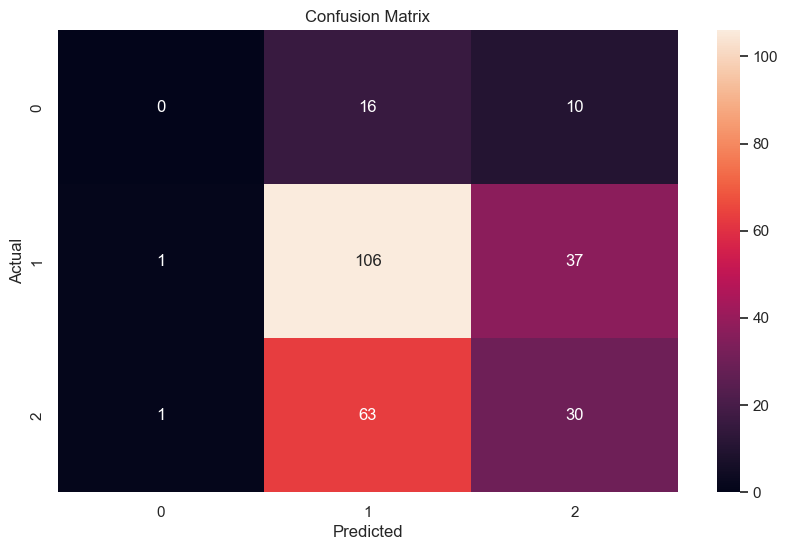

In [198]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

plot_confusion_matrix(test_y, pred_y)

### Combining Non-text Features

In [199]:
df_train_test

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,1
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,1
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,2
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,2
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,1
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,1
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,2
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,1


In [200]:
# Create train, val and test datasets

train_val_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [201]:
train_df.shape, val_df.shape, test_df.shape 

((842, 4), (211, 4), (264, 4))

In [144]:
# train_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42)

In [202]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler.fit_transform(train_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
train_df

# normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df

val_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler.transform(val_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
val_df

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler.transform(test_df[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
test_df

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
261,Singapore's table tennis pair wins men's doubl...,1.000000,1.000000,1
991,Commentary: Seeking inspiration? Look no furth...,1.000000,1.000000,1
554,Nintendo sells 10m copies of 'Zelda' in 3 days...,0.832321,0.955429,1
49,Woman lost $20k to bubble tea survey scam afte...,0.832321,0.955429,2
857,Four Singaporeans injured after car crash on N...,0.832321,0.955429,2
...,...,...,...,...
573,"Najib gets 2-day MC for diarrhoea, 1MDB corrup...",0.453160,0.701374,1
948,Diner Allegedly Served Undercooked Chicken At ...,0.127382,0.328548,1
682,MAS launches new S$10 coin to commemorate Lee ...,0.453160,0.701374,2
170,"The Big Read: Beyond IRs and new attractions, ...",1.000000,1.000000,2


In [203]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [234]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[['mean_monthly_visits', 'mean_monthly_unique_visitors']].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [235]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    sentence_model.train()
    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    sentence_model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [241]:
# Create Datasets
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)
test_dataset = CustomDataset(test_df)

# Create DataLoaders
batch_size = 32  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model = NumericModel(2, 50, 768)  

# Instantiate FinalModel
final_model = FinalModel(1152, 32, 3)

# Define the criterion and the optimizer
criterion = nn.NLLLoss()
optimizer = Adam(list(numeric_model.parameters()) + list(final_model.parameters()), lr=0.001)

In [242]:
N_EPOCHS = 100

# Save train and validation losses

train_losses = []
val_losses = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader, sentence_model, numeric_model, final_model, criterion, optimizer)
    valid_loss = evaluate(val_dataloader, sentence_model, numeric_model, final_model, criterion)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 20 and val_losses[epoch-1] < val_losses[epoch]:
        break

Epoch 0: Train Loss: 0.9524285925759209, Validation Loss: 0.9040770104953221
Epoch 1: Train Loss: 0.9311333232455783, Validation Loss: 0.9009281992912292
Epoch 2: Train Loss: 0.9256442078837642, Validation Loss: 0.8963160344532558
Epoch 3: Train Loss: 0.9193383079987986, Validation Loss: 0.8960135749408177
Epoch 4: Train Loss: 0.9163662349736249, Validation Loss: 0.8967038222721645
Epoch 5: Train Loss: 0.9042269101849308, Validation Loss: 0.8904062509536743
Epoch 6: Train Loss: 0.8990026226750126, Validation Loss: 0.8868626611573356
Epoch 7: Train Loss: 0.891171740161048, Validation Loss: 0.896841015134539
Epoch 8: Train Loss: 0.8906964549311885, Validation Loss: 0.8890317848750523
Epoch 9: Train Loss: 0.8833872918729428, Validation Loss: 0.8883314899035862
Epoch 10: Train Loss: 0.8790157194490786, Validation Loss: 0.8851065124784198
Epoch 11: Train Loss: 0.8718759417533875, Validation Loss: 0.8841240065438407
Epoch 12: Train Loss: 0.8685689921732302, Validation Loss: 0.895431876182556

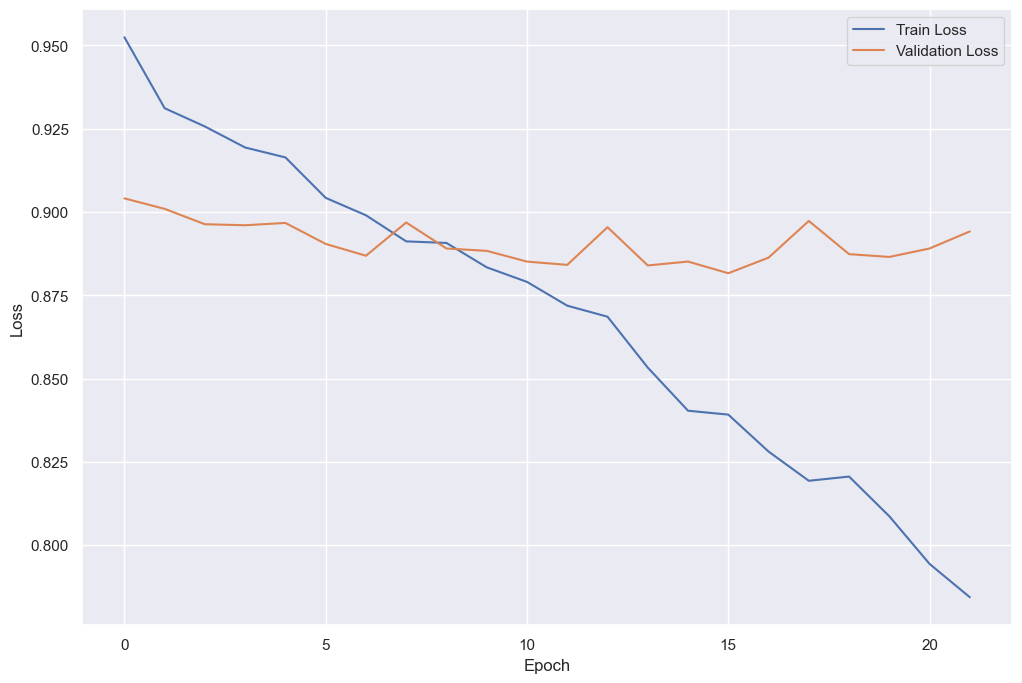

In [243]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [244]:
final_model.eval()  # Set the model to evaluation mode

predictions = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader:  # We don't care about labels here
        texts = [sentence_model.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        predictions.extend(predicted.tolist())  # Convert tensor to list and append to predictions

predictions = np.array(predictions)  # Convert predictions to NumPy array

In [245]:
# plot confusion matrix

test_y = test_df['label'].values

evaluate_predictions(test_y, predictions)

,macro
accuracy,0.561
precision,0.679
recall,0.372
f1,0.351


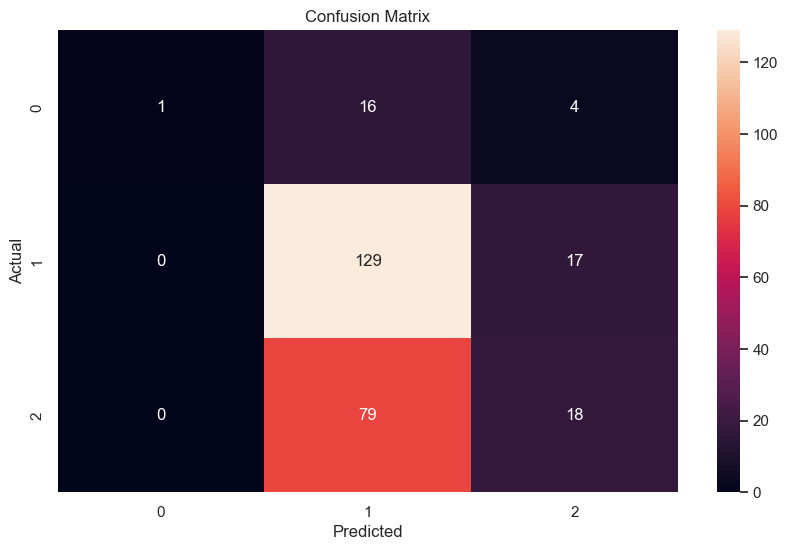

In [246]:
plot_confusion_matrix(test_y, predictions)